In [1]:
import keras
from keras.layers import Activation, Dropout, Dense, BatchNormalization
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pylab as pl
import seaborn as sns
import gc
import bayes_opt
from IPython.display import SVG

%load_ext autoreload
%autoreload 1
%aimport utils
from utils import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(5)

# Input

### a query for SDSS CasJobs server (DR13)

WorkingSpecPhoto.csv:
SELECT sp.class, sp.z,
  sp.psfMag_u, sp.psfMag_g, sp.psfMag_r, sp.psfMag_i, sp.psfMag_z,
  sp.fiberMag_u, sp.fiberMag_g, sp.fiberMag_r, sp.fiberMag_i, sp.fiberMag_z,
  sp.petroMag_u, sp.petroMag_g, sp.petroMag_r, sp.petroMag_i, sp.petroMag_z,
  sp.modelMag_u, sp.modelMag_g, sp.modelMag_r, sp.modelMag_i, sp.modelMag_z,
  sp.cModelMag_u, sp.cModelMag_g, sp.cModelMag_r, sp.cModelMag_i, sp.cModelMag_z, 
  sp.psfMag_u, sp.psfMag_g, sp.psfMag_r, sp.psfMag_i, sp.psfMag_z,
  sp.fiberMag_u, sp.fiberMag_g, sp.fiberMag_r, sp.fiberMag_i, sp.fiberMag_z,
  sp.petroMag_u, sp.petroMag_g, sp.petroMag_r, sp.petroMag_i, sp.petroMag_z,
  sp.modelMag_u, sp.modelMag_g, sp.modelMag_r, sp.modelMag_i, sp.modelMag_z,
  sp.cModelMag_u, sp.cModelMag_g, sp.cModelMag_r, sp.cModelMag_i, sp.cModelMag_z, 
  sp.fiberMagErr_u, sp.fiberMagErr_g, sp.fiberMagErr_r, sp.fiberMagErr_i, sp.fiberMagErr_z,
  sp.petroMagErr_u, sp.petroMagErr_g, sp.petroMagErr_r, sp.petroMagErr_i, sp.petroMagErr_z,
  sp.modelMagErr_u, sp.modelMagErr_g, sp.modelMagErr_r, sp.modelMagErr_i, sp.modelMagErr_z,
  sp.cModelMagErr_u, sp.cModelMagErr_g, sp.cModelMagErr_r, sp.cModelMagErr_i, sp.cModelMagErr_z, 
  sp.psfMagErr_u, sp.psfMagErr_g, sp.psfMagErr_r, sp.psfMagErr_i, sp.psfMagErr_z,
  sp.fiberMagErr_u, sp.fiberMagErr_g, sp.fiberMagErr_r, sp.fiberMagErr_i, sp.fiberMagErr_z,
  sp.petroMagErr_u, sp.petroMagErr_g, sp.petroMagErr_r, sp.petroMagErr_i, sp.petroMagErr_z,
  sp.modelMagErr_u, sp.modelMagErr_g, sp.modelMagErr_r, sp.modelMagErr_i, sp.modelMagErr_z,
  sp.cModelMagErr_u, sp.cModelMagErr_g, sp.cModelMagErr_r, sp.cModelMagErr_i, sp.cModelMagErr_z, 
  sp.extinction_u, sp.extinction_g, sp.extinction_r, sp.extinction_i, sp.extinction_z
INTO mydb.SpecFull
FROM SpecPhoto sp
WHERE sp.zerr/(1 + sp.z) BETWEEN 0 and 0.002 AND
  sp.dered_u >= 0 AND sp.dered_g >= 0 AND
  sp.dered_r >= 0 AND sp.dered_i >= 0 AND
  sp.dered_z >= 0 AND sp.zWarning = 0

In [3]:
data = pd.read_csv('../data/WorkingSpecPhoto.csv')
# del data['specz_err'], data['objid']
data.head()

,specz,class,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,...,cModelMagErr_u,cModelMagErr_g,cModelMagErr_r,cModelMagErr_i,cModelMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z
0,0.000439,STAR,20.53326,18.79244,18.58743,17.73743,17.54449,0.046314,0.013261,0.016487,...,0.048365,0.010202,0.007820,0.008530,0.014317,0.152693,0.118977,0.082308,0.061163,0.045494
1,-0.000072,STAR,17.29640,16.42476,16.04994,15.90507,15.86059,0.021483,0.015190,0.014618,...,0.009082,0.004037,0.004280,0.004363,0.006356,0.166750,0.129931,0.089886,0.066795,0.049683
2,-0.000432,STAR,22.72649,20.42501,19.27684,18.79184,18.56272,0.246067,0.027813,0.018546,...,0.330533,0.022433,0.012771,0.012687,0.034396,0.163975,0.127768,0.088389,0.065683,0.048856
3,-0.000055,STAR,22.04301,19.68031,18.47200,17.97659,18.25145,0.138901,0.020268,0.011865,...,0.150079,0.014375,0.009291,0.007915,0.021296,0.162593,0.126691,0.087645,0.065129,0.048444
4,-0.000480,STAR,18.76535,18.40752,18.33293,17.52021,16.74674,0.027702,0.020852,0.015042,...,0.020063,0.007102,0.007862,0.006444,0.009273,0.155525,0.121184,0.083835,0.062298,0.046338


In [4]:
bands = ['u', 'g', 'r', 'i', 'z']
prefixes = ['psfMag_', 'fiberMag_', 'modelMag_', 'petroMag_', 'cModelMag_']
for prefix in prefixes:
    for b in bands:
        data[prefix + b] = data[prefix + b] - data['extinction_' + b]
        
for prefix in prefixes:
    for i in range(len(bands)-1):
        for j in range(i+1, len(bands)):
            color = bands[i] + '-' + bands[j]
            data[prefix + color] = data[prefix + bands[i]] - data[prefix + bands[j]]

for b in bands:
    data['psfMag_' + b + '-cModelMag_' + b] = data['psfMag_' + b] - data['cModelMag_' + b]
#     data['fiberMag_' + b + '-petroMag_' + b] = np.maximum(-10, data['fiberMag_' + b] - data['petroMag_' + b])
#     data['cModelMag_' + b + '-fiberMag_' + b] = data['cModelMag_' + b] - data['fiberMag_' + b]

for b in bands:
    del data['extinction_' + b]
gc.collect()

202

In [5]:
train, test = train_test_split(data, test_size=0.4)
test, validation = train_test_split(test, test_size=0.5)
del data
gc.collect()

24

In [6]:
y_train, y_validation, y_test = train.specz.values, validation.specz.values, test.specz.values
object_class_train, object_class_validation, object_class_test = train['class'].values, validation['class'].values, test['class'].values
del train['specz'], test['specz'], validation['specz']
del train['class'], test['class'], validation['class']

In [7]:
scaler = StandardScaler(copy=False)
train = scaler.fit_transform(train)
test = scaler.transform(test)
validation = scaler.transform(validation)

In [8]:
print(train.shape[1], 'features')
train.shape[0], validation.shape[0], test.shape[0]

105 features


(2025120, 675041, 675040)

# Model

In [ ]:
batch_size = 128
model = model_nn(train.shape[1], 5, batch_normalization=True, dropout=0, l2=10**-5, neurons_decay=0, starting_power=1)

In [24]:
history = model.fit(train, y_train, validation_data=(validation, y_validation), epochs=3, batch_size=batch_size, 
                    verbose=0)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


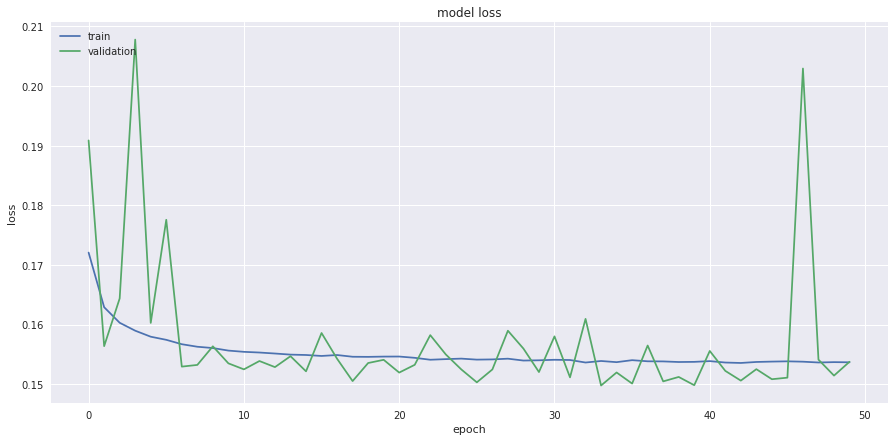

In [ ]:
plot_history(history)

In [31]:
predict = model.predict(test, batch_size=batch_size).reshape(-1)
metrics = metrics_with_object_class(y_test, predict, object_class_test, 'MLP')
metrics

,RMSE_znorm,bias_znorm,std_znorm,RMSE,|znorm| > 0.15 (%),|znorm| > 3std (%)
MLP,0.148366,-0.025213,0.146208,0.470154,9.286251,4.058124
MLP (GALAXY only),0.046747,-0.007462,0.046147,0.066214,1.348021,1.549887
MLP (STAR only),0.145287,0.040055,0.139656,0.145275,7.673208,2.965571
MLP (QSO only),0.364964,-0.245101,0.270415,1.338229,56.137058,0.147896


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


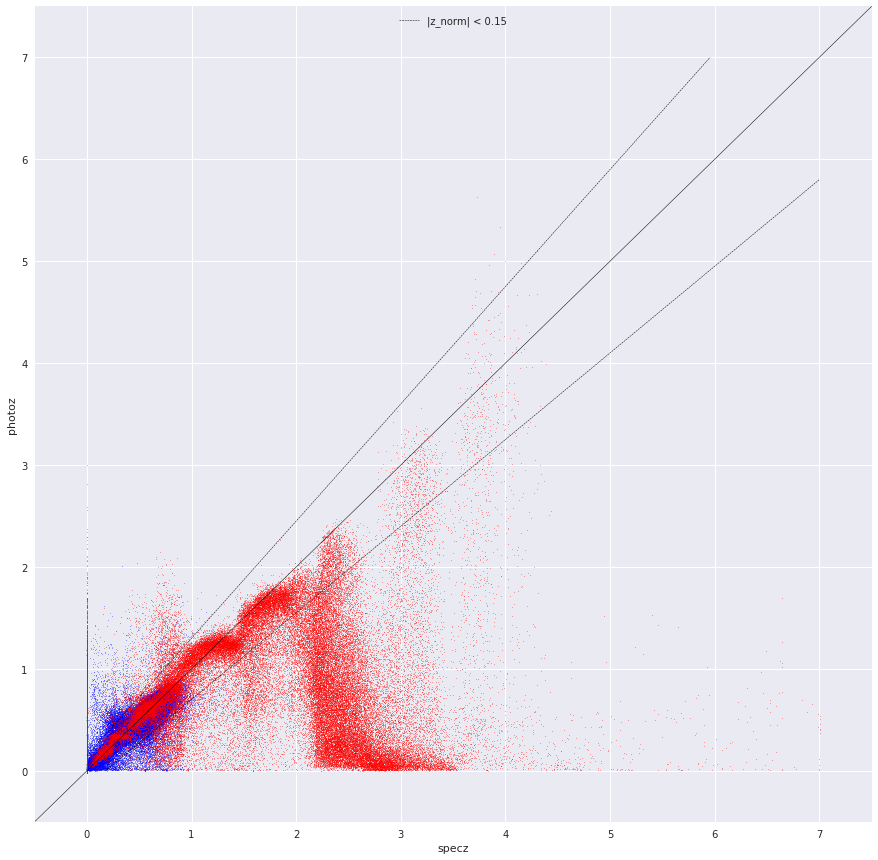

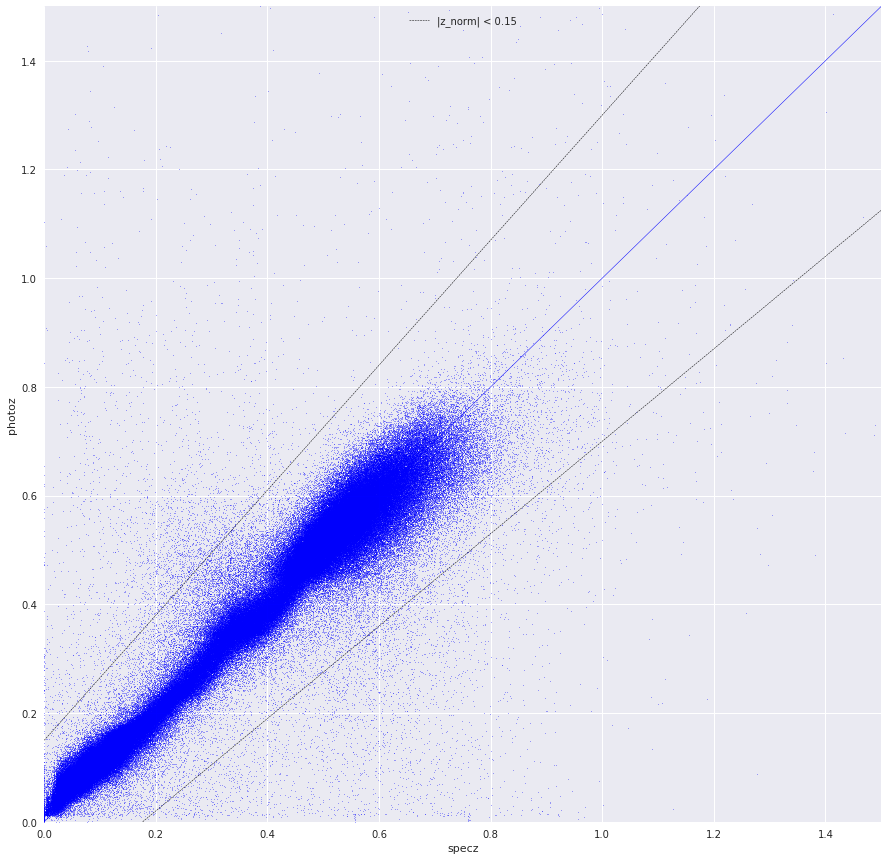

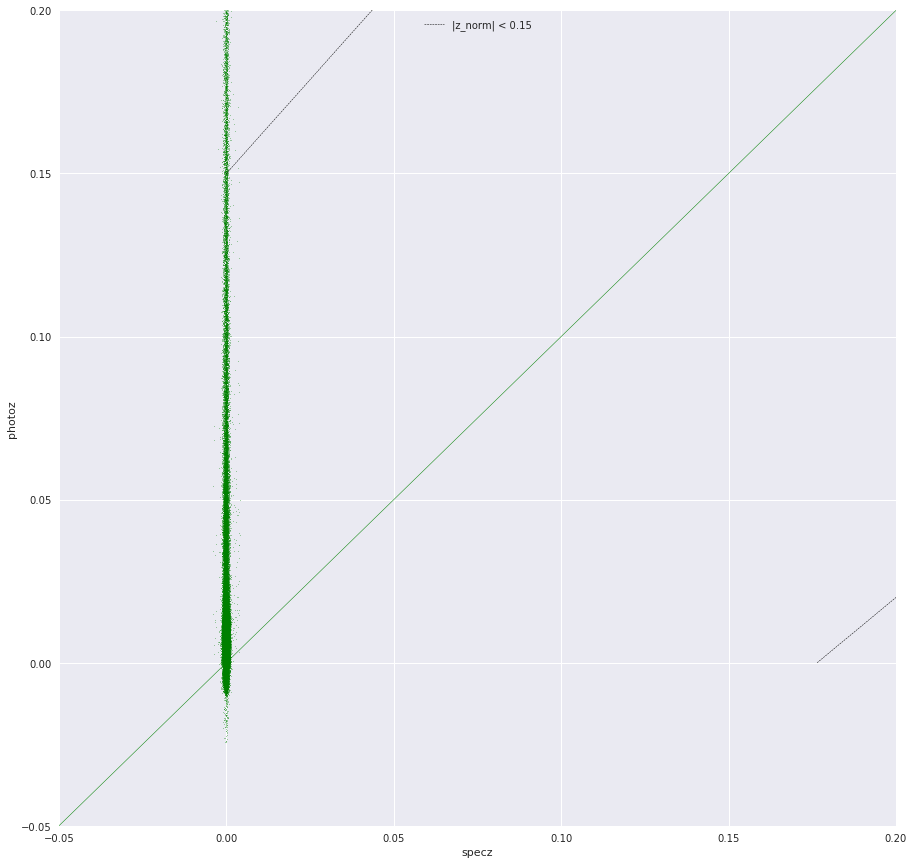

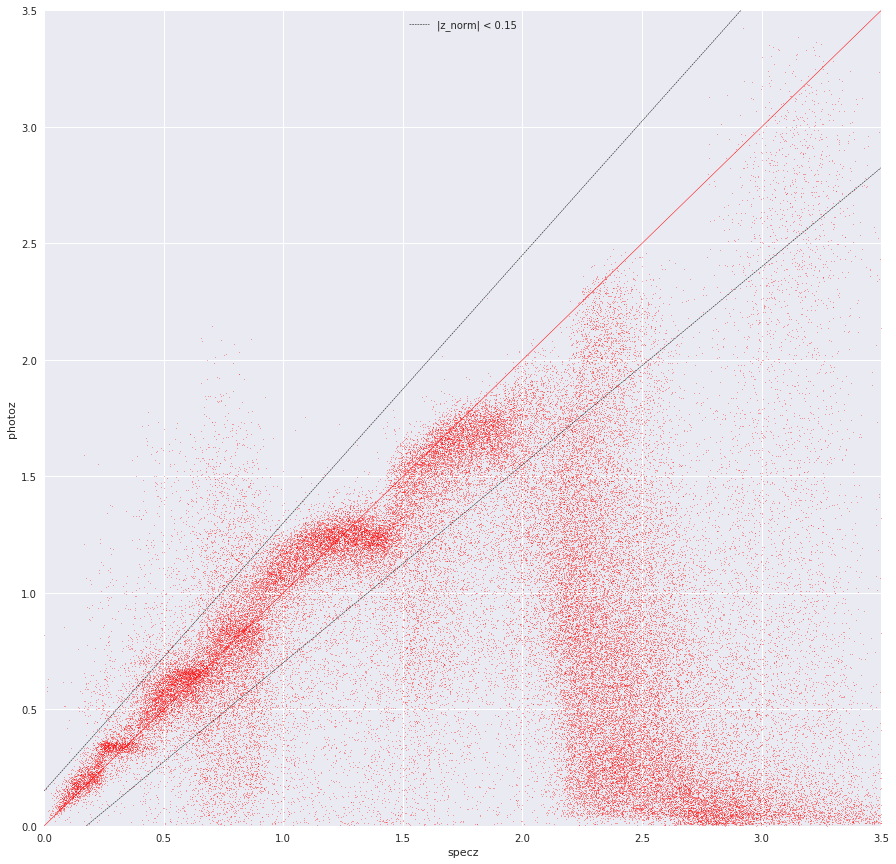

In [ ]:
plot_quality(y_test, predict, object_class_test)